***
# __Imports__
***

In [1]:
from statistics import mean

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from aqmd_pylib.aqmd_lib import data_toolkit as dtk
from aqmd_pylib.aqmd_lib.util import nLoop
from aqmd_pylib.aqmd_lib import util

***
# __Settings__
***

In [2]:
RANDOM_STATE = 42
SAVE_FIGURES = True
USE_SCALED = False
PARALLEL_CORES = -1  # "-1" will use all cores available

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

***
# __Load Data__
***

In [3]:
iowa_pm25 = pd.read_csv('../data/complete_sets/iowa/iowa_full_pm25_TravelTime.csv')
iowa_pm25

,datetime-America/Los_Angeles,Iowa PM2.5 [ug/m3],year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph)
0,2021-04-21 14:00:00-07:00,12.830752,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.077474,14.268458,18.500068,12.143368,20.245579,18.390919
1,2021-04-21 14:15:00-07:00,12.735159,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,14.725029,13.229034,17.702651,12.384627,20.089243,18.833312
2,2021-04-21 14:30:00-07:00,12.639567,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.650210,14.067494,16.695183,13.357705,20.404368,18.768815
3,2021-04-21 14:45:00-07:00,12.543974,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.551295,14.796919,16.832029,12.721624,19.935302,15.481621
4,2021-04-21 15:00:00-07:00,12.448382,2021,4,21,0,0,0,1,0,0,0,18.31,1011,55,1.79,275,9.0,13.262970,14.067494,18.172633,12.550864,19.560578,17.020167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4150,2021-07-10 21:30:00-07:00,2.965718,2021,7,10,0,0,0,0,0,0,1,26.71,1013,46,0.45,174,4.0,15.328514,15.729009,18.668250,12.467192,24.542990,20.998061
4151,2021-07-10 22:00:00-07:00,2.961908,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.852435,15.248734,18.839518,13.262970,24.895281,20.223225
4152,2021-07-10 22:30:00-07:00,2.958098,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.955811,15.980673,20.535075,12.384627,24.427764,20.223225
4153,2021-07-10 23:00:00-07:00,2.954288,2021,7,10,0,0,0,0,0,0,1,24.14,1014,49,0.00,0,9.0,14.725029,16.240521,19.557214,14.496734,23.867495,20.603361


In [4]:
iowa_pm25 = dtk.df_str2dt(iowa_pm25, 'datetime-America/Los_Angeles',
                          '%Y-%m-%d %H:%M:%S%z', curr_tz='America/Los_Angeles', overwrite=True)
iowa_pm25.set_index('datetime-America/Los_Angeles', inplace=True)
iowa_pm25.info()
iowa_pm25

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4155 entries, 2021-04-21 14:00:00-07:00 to 2021-07-10 23:30:00-07:00
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Iowa PM2.5 [ug/m3]        4155 non-null   float64
 1   year                      4155 non-null   int64  
 2   month                     4155 non-null   int64  
 3   day                       4155 non-null   int64  
 4   dayofweek_Sunday          4155 non-null   int64  
 5   dayofweek_Monday          4155 non-null   int64  
 6   dayofweek_Tuesday         4155 non-null   int64  
 7   dayofweek_Wednesday       4155 non-null   int64  
 8   dayofweek_Thursday        4155 non-null   int64  
 9   dayofweek_Friday          4155 non-null   int64  
 10  dayofweek_Saturday        4155 non-null   int64  
 11  temp                      4155 non-null   float64
 12  pressure                  4155 non-null   int64  
 13  humidity       

,Iowa PM2.5 [ug/m3],year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph)
datetime-America/Los_Angeles,,,,,,,,,,,,,,,,,,,,,,,
2021-04-21 14:00:00-07:00,12.830752,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.077474,14.268458,18.500068,12.143368,20.245579,18.390919
2021-04-21 14:15:00-07:00,12.735159,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,14.725029,13.229034,17.702651,12.384627,20.089243,18.833312
2021-04-21 14:30:00-07:00,12.639567,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.650210,14.067494,16.695183,13.357705,20.404368,18.768815
2021-04-21 14:45:00-07:00,12.543974,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.551295,14.796919,16.832029,12.721624,19.935302,15.481621
2021-04-21 15:00:00-07:00,12.448382,2021,4,21,0,0,0,1,0,0,0,18.31,1011,55,1.79,275,9.0,13.262970,14.067494,18.172633,12.550864,19.560578,17.020167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 21:30:00-07:00,2.965718,2021,7,10,0,0,0,0,0,0,1,26.71,1013,46,0.45,174,4.0,15.328514,15.729009,18.668250,12.467192,24.542990,20.998061
2021-07-10 22:00:00-07:00,2.961908,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.852435,15.248734,18.839518,13.262970,24.895281,20.223225
2021-07-10 22:30:00-07:00,2.958098,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.955811,15.980673,20.535075,12.384627,24.427764,20.223225


In [5]:

continuous_variables = [
    'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
    'PM2.5 Background [ug/m3]',
    'Local 1 (mph)',
    'Local 2 (mph)',
    'Local 9 (mph)',
    'Local 10 (mph)',
    'Fwy 1 (mph)',
    'Fwy 4 (mph)'
]
iowa_scaled = iowa_pm25.copy()
for feat in continuous_variables:
    iowa_scaled[feat] = StandardScaler().fit_transform(iowa_scaled.loc[:, [feat]])
iowa_scaled

,Iowa PM2.5 [ug/m3],year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph)
datetime-America/Los_Angeles,,,,,,,,,,,,,,,,,,,,,,,
2021-04-21 14:00:00-07:00,12.830752,2021,4,21,0,0,0,1,0,0,0,-0.991653,-0.150586,0.213671,0.901123,1.047564,-0.336371,-0.000807,0.012009,-0.016102,-0.008260,0.013485,-0.012496
2021-04-21 14:15:00-07:00,12.735159,2021,4,21,0,0,0,1,0,0,0,-0.991653,-0.150586,0.213671,0.901123,1.047564,-0.336371,0.027366,-0.007208,-0.040813,-0.002423,0.012372,-0.007316
2021-04-21 14:30:00-07:00,12.639567,2021,4,21,0,0,0,1,0,0,0,-0.991653,-0.150586,0.213671,0.901123,1.047564,-0.336371,0.008987,0.008293,-0.072034,0.021119,0.014617,-0.008071
2021-04-21 14:45:00-07:00,12.543974,2021,4,21,0,0,0,1,0,0,0,-0.991653,-0.150586,0.213671,0.901123,1.047564,-0.336371,0.007296,0.021779,-0.067793,0.005730,0.011275,-0.046564
2021-04-21 15:00:00-07:00,12.448382,2021,4,21,0,0,0,1,0,0,0,-0.935967,-0.492866,0.109865,0.388302,0.780878,-0.193194,0.002365,0.008293,-0.026249,0.001599,0.008605,-0.028548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 21:30:00-07:00,2.965718,2021,7,10,0,0,0,0,0,0,1,0.263432,0.191693,-0.357263,-1.138767,-0.390225,-0.551137,0.037686,0.039012,-0.010890,-0.000426,0.044101,0.018033
2021-07-10 22:00:00-07:00,2.961908,2021,7,10,0,0,0,0,0,0,1,0.133498,0.533972,-0.357263,-0.637341,0.224314,-0.407960,0.012445,0.030132,-0.005583,0.018827,0.046611,0.008960
2021-07-10 22:30:00-07:00,2.958098,2021,7,10,0,0,0,0,0,0,1,0.133498,0.533972,-0.357263,-0.637341,0.224314,-0.407960,0.014213,0.043664,0.046961,-0.002423,0.043280,0.008960


In [6]:
if USE_SCALED:
    iowa_x = iowa_scaled.drop(columns='Iowa PM2.5 [ug/m3]')
else:
    iowa_x = iowa_pm25.drop(columns='Iowa PM2.5 [ug/m3]')
iowa_x.info()
iowa_x

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4155 entries, 2021-04-21 14:00:00-07:00 to 2021-07-10 23:30:00-07:00
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   year                      4155 non-null   int64  
 1   month                     4155 non-null   int64  
 2   day                       4155 non-null   int64  
 3   dayofweek_Sunday          4155 non-null   int64  
 4   dayofweek_Monday          4155 non-null   int64  
 5   dayofweek_Tuesday         4155 non-null   int64  
 6   dayofweek_Wednesday       4155 non-null   int64  
 7   dayofweek_Thursday        4155 non-null   int64  
 8   dayofweek_Friday          4155 non-null   int64  
 9   dayofweek_Saturday        4155 non-null   int64  
 10  temp                      4155 non-null   float64
 11  pressure                  4155 non-null   int64  
 12  humidity                  4155 non-null   int64  
 13  wind_speed     

,year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph)
datetime-America/Los_Angeles,,,,,,,,,,,,,,,,,,,,,,
2021-04-21 14:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.077474,14.268458,18.500068,12.143368,20.245579,18.390919
2021-04-21 14:15:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,14.725029,13.229034,17.702651,12.384627,20.089243,18.833312
2021-04-21 14:30:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.650210,14.067494,16.695183,13.357705,20.404368,18.768815
2021-04-21 14:45:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.551295,14.796919,16.832029,12.721624,19.935302,15.481621
2021-04-21 15:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,18.31,1011,55,1.79,275,9.0,13.262970,14.067494,18.172633,12.550864,19.560578,17.020167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 21:30:00-07:00,2021,7,10,0,0,0,0,0,0,1,26.71,1013,46,0.45,174,4.0,15.328514,15.729009,18.668250,12.467192,24.542990,20.998061
2021-07-10 22:00:00-07:00,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.852435,15.248734,18.839518,13.262970,24.895281,20.223225
2021-07-10 22:30:00-07:00,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.955811,15.980673,20.535075,12.384627,24.427764,20.223225


In [7]:
iowa_y = iowa_pm25.loc[:, 'Iowa PM2.5 [ug/m3]']
iowa_y

datetime-America/Los_Angeles
2021-04-21 14:00:00-07:00    12.830752
2021-04-21 14:15:00-07:00    12.735159
2021-04-21 14:30:00-07:00    12.639567
2021-04-21 14:45:00-07:00    12.543974
2021-04-21 15:00:00-07:00    12.448382
                               ...    
2021-07-10 21:30:00-07:00     2.965718
2021-07-10 22:00:00-07:00     2.961908
2021-07-10 22:30:00-07:00     2.958098
2021-07-10 23:00:00-07:00     2.954288
2021-07-10 23:30:00-07:00     2.950479
Name: Iowa PM2.5 [ug/m3], Length: 4155, dtype: float64

In [8]:
iowa_train_x, iowa_test_x, iowa_train_y, iowa_test_y = train_test_split(
    iowa_x, iowa_y,
    test_size=0.2,
    random_state=RANDOM_STATE
)

***
# __Gradient Boosted Regression Model__
***

***
> ## __Model Parameters__
***

In [9]:
gbt_model_params = {
    'loss'                    : 'huber',
    'learning_rate'           : 0.001,
    'verbose'                 : True,
    'n_estimators'            : 9000,
    'subsample'               : 1.0,
    'criterion'               : 'friedman_mse',
    'min_samples_split'       : 2,
    'min_samples_leaf'        : 2,
    'min_weight_fraction_leaf': 0.0,
    'max_depth'               : 4,
    'min_impurity_decrease'   : 0.0,
    'init'                    : None,
    'random_state'            : RANDOM_STATE,
    'max_features'            : 'auto',
    'alpha'                   : 0.9,
    'max_leaf_nodes'          : None,
    'warm_start'              : False,
    'validation_fraction'     : 0.1,
    'n_iter_no_change'        : 100

}

***
> ## __Cross Validation - Model Evaluation__
***

In [10]:
gbt_model_cv = GradientBoostingRegressor(**gbt_model_params)
cv_split = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)
cv_results = cross_validate(gbt_model_cv,
                            X=iowa_x,
                            y=iowa_y,
                            n_jobs=PARALLEL_CORES,
                            cv=cv_split,
                            scoring=('r2','explained_variance' ,'neg_mean_squared_error','neg_root_mean_squared_error'),
                            return_train_score=True,
                            verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.3min remaining:  6.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.3min finished


In [11]:
print(cv_results.keys())
print(
    f'\nCross Validation Results:\n'
    f'  Fit Time: {mean(cv_results["fit_time"])}\n'
    f'  Score Time: {mean(cv_results["score_time"])}\n'
    f'  Test R2: {mean(cv_results["test_r2"])}\n'
    f'  Train R2: {mean(cv_results["train_r2"])}\n'
    f'  Test MSE: {abs(mean(cv_results["test_neg_mean_squared_error"]))}\n'
    f'  Train MSE: {abs(mean(cv_results["train_neg_mean_squared_error"]))}\n'
    f'  Test RMSE: {abs(mean(cv_results["test_neg_root_mean_squared_error"]))}\n'
    f'  Train RMSE: {abs(mean(cv_results["train_neg_root_mean_squared_error"]))}\n'
    f'  Test Explained Variance: {mean(cv_results["test_explained_variance"])}\n'
    f'  Train Explained Variance: {mean(cv_results["train_explained_variance"])}\n'
)

dict_keys(['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_explained_variance', 'train_explained_variance', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error', 'test_neg_root_mean_squared_error', 'train_neg_root_mean_squared_error'])

Cross Validation Results:
  Fit Time: 254.15046153068542
  Score Time: 0.16206398010253906
  Test R2: 0.929698962386417
  Train R2: 0.9453284966808974
  Test MSE: 1.8535846875504431
  Train MSE: 1.443436809104425
  Test RMSE: 1.3599817819180342
  Train RMSE: 1.2012897700989764
  Test Explained Variance: 0.9299866620966403
  Train Explained Variance: 0.9455438514428121



In [12]:
gbt_model_cvp = GradientBoostingRegressor(**gbt_model_params)

In [13]:
cv_y = cross_val_predict(gbt_model_cvp,
                         X=iowa_x,
                         y=iowa_y,
                         cv=cv_split,
                         n_jobs=PARALLEL_CORES,
                         verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.7min remaining:  5.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.8min finished


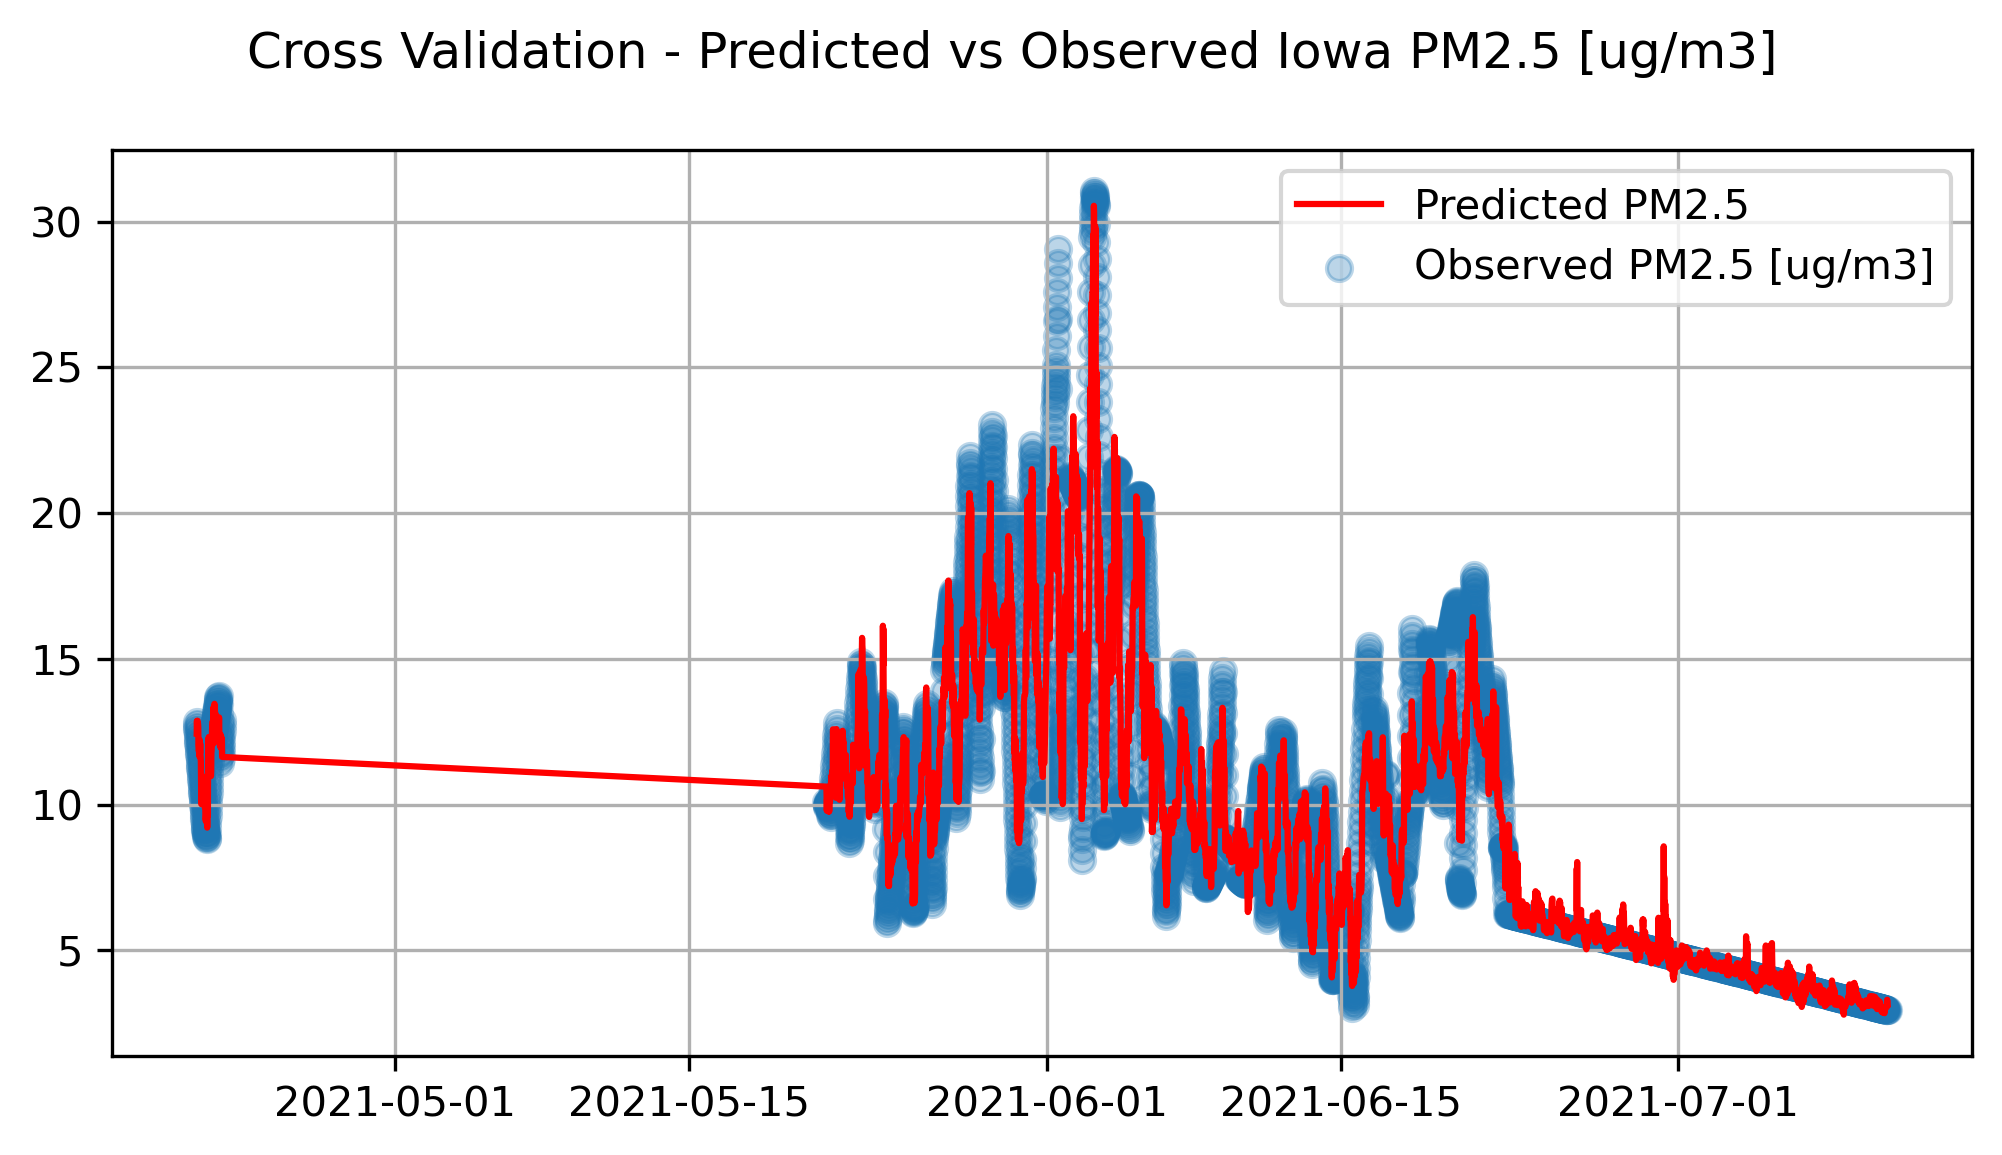

In [14]:
cv_fig, cv_ax = plt.subplots(dpi=300, figsize=(8, 4))
cv_iowa = pd.concat([iowa_x, iowa_y], axis=1)
cv_iowa['Predicted Iowa PM2.5 [ug/m3]'] = cv_y
cv_iowa.sort_index(inplace=True)
cv_iowa.reset_index(inplace=True)
cv_ax.scatter(
    cv_iowa.loc[:, 'datetime-America/Los_Angeles'],
    cv_iowa.loc[:, 'Iowa PM2.5 [ug/m3]'],
    label='Observed PM2.5 [ug/m3]',
    alpha=0.3
)
cv_ax.plot(
    cv_iowa.loc[:, 'datetime-America/Los_Angeles'],
    cv_iowa.loc[:, 'Predicted Iowa PM2.5 [ug/m3]'],
    label='Predicted PM2.5',
    color='red'
)
cv_fig.suptitle('Cross Validation - Predicted vs Observed Iowa PM2.5 [ug/m3]')
cv_ax.legend()
cv_ax.grid()
if SAVE_FIGURES:
    cv_fig.savefig('../graphs/travel_time/cross_validation_pm25.png', dpi=300)

***
> ## __Leave One Out - Model Evaluation__
***

In [15]:
gbt_model_loo = GradientBoostingRegressor(**gbt_model_params)
gbt_model_loo.fit(X=iowa_train_x, y=iowa_train_y)
iowa_test_predY = gbt_model_loo.predict(iowa_test_x)

      Iter       Train Loss   Remaining Time 
         1          12.2888            1.80m
         2          12.2720            2.06m
         3          12.2552            2.02m
         4          12.2384            1.96m
         5          12.2217            1.93m
         6          12.2050            1.91m
         7          12.1883            1.91m
         8          12.1716            1.92m
         9          12.1550            1.92m
        10          12.1360            1.92m


C:\Users\Alex\anaconda3\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


        20          11.9530            2.15m
        30          11.7745            2.16m
        40          11.6049            2.26m
        50          11.4429            2.49m
        60          11.2897            2.69m
        70          11.1344            2.76m
        80          10.9810            2.78m
        90          10.8192            2.78m
       100          10.6768            2.76m
       200           9.3754            2.50m
       300           8.2395            2.37m
       400           7.2889            2.25m
       500           6.4961            2.16m
       600           5.8004            2.09m
       700           5.2098            2.09m
       800           4.6969            2.22m
       900           4.2800            2.23m
      1000           3.9410            2.21m
      2000           2.1248            2.22m
      3000           1.4782            1.94m
      4000           1.1422            1.57m
      5000           0.8975            1.23m
      6000

In [16]:
iowa_test = pd.concat([iowa_test_x, iowa_test_y], axis=1)
iowa_test['pred Iowa PM2.5 [ug/m3]'] = iowa_test_predY
iowa_test.sort_index(inplace=True)
iowa_test.reset_index(inplace=True)
iowa_test.info()
iowa_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 25 columns):
 #   Column                        Non-Null Count  Dtype                                 
---  ------                        --------------  -----                                 
 0   datetime-America/Los_Angeles  831 non-null    datetime64[ns, pytz.FixedOffset(-420)]
 1   year                          831 non-null    int64                                 
 2   month                         831 non-null    int64                                 
 3   day                           831 non-null    int64                                 
 4   dayofweek_Sunday              831 non-null    int64                                 
 5   dayofweek_Monday              831 non-null    int64                                 
 6   dayofweek_Tuesday             831 non-null    int64                                 
 7   dayofweek_Wednesday           831 non-null    int64                             

,datetime-America/Los_Angeles,year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph),Iowa PM2.5 [ug/m3],pred Iowa PM2.5 [ug/m3]
0,2021-04-21 15:30:00-07:00,2021,4,21,0,0,0,1,0,0,0,18.31,1011,55,1.79,275,9.0,12.986658,13.776442,18.500068,12.467192,20.089243,15.793931,12.257197,12.993093
1,2021-04-21 16:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.77,1011,56,4.02,296,6.0,15.714947,14.580906,18.013224,12.384627,19.342431,16.915105,12.066012,12.000792
2,2021-04-21 17:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.00,1011,58,3.13,309,6.0,16.697132,14.796919,16.428060,12.222737,20.484700,14.088673,11.683641,12.005833
3,2021-04-21 17:30:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.00,1011,58,3.13,309,6.0,14.275410,12.484901,14.989106,10.506060,20.896039,13.498753,11.492456,11.972357
4,2021-04-21 18:15:00-07:00,2021,4,21,0,0,0,1,0,0,0,16.07,1011,63,3.58,307,6.0,14.060742,14.580906,17.702651,12.550864,22.524302,17.288624,11.205678,11.697891
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
826,2021-07-10 18:00:00-07:00,2021,7,10,0,0,0,0,0,0,1,33.23,1011,32,2.24,272,6.0,16.261554,14.268458,18.500068,13.852435,23.758511,19.029493,2.992387,3.006804
827,2021-07-10 18:15:00-07:00,2021,7,10,0,0,0,0,0,0,1,33.23,1011,32,2.24,272,6.0,14.060742,15.248734,18.334889,14.385221,23.867495,19.162566,2.990482,2.956788
828,2021-07-10 19:15:00-07:00,2021,7,10,0,0,0,0,0,0,1,31.59,1012,34,2.24,234,6.0,12.721624,14.167263,18.172633,12.384627,24.427764,19.714007,2.982862,2.987098
829,2021-07-10 19:45:00-07:00,2021,7,10,0,0,0,0,0,0,1,31.59,1012,34,2.24,234,6.0,13.077474,13.682083,20.331758,13.077474,24.313616,20.603361,2.979052,2.892657


In [17]:
print(
    f'\nLeave One Out Results:\n'
    f'  R2: {metrics.r2_score(iowa_test_y, iowa_test_predY)}\n'
    f'  MSE:{metrics.mean_squared_error(iowa_test_y, iowa_test_predY, squared=True)}\n'
    f'  RMSE: {metrics.mean_squared_error(iowa_test_y, iowa_test_predY, squared=False)}\n'
    f'  Explained Variance {metrics.explained_variance_score(iowa_test_y, iowa_test_predY)}\n'
)


Leave One Out Results:
  R2: 0.9305838513352889
  MSE:1.8945100158089951
  RMSE: 1.3764120080154034
  Explained Variance 0.9309267530688339



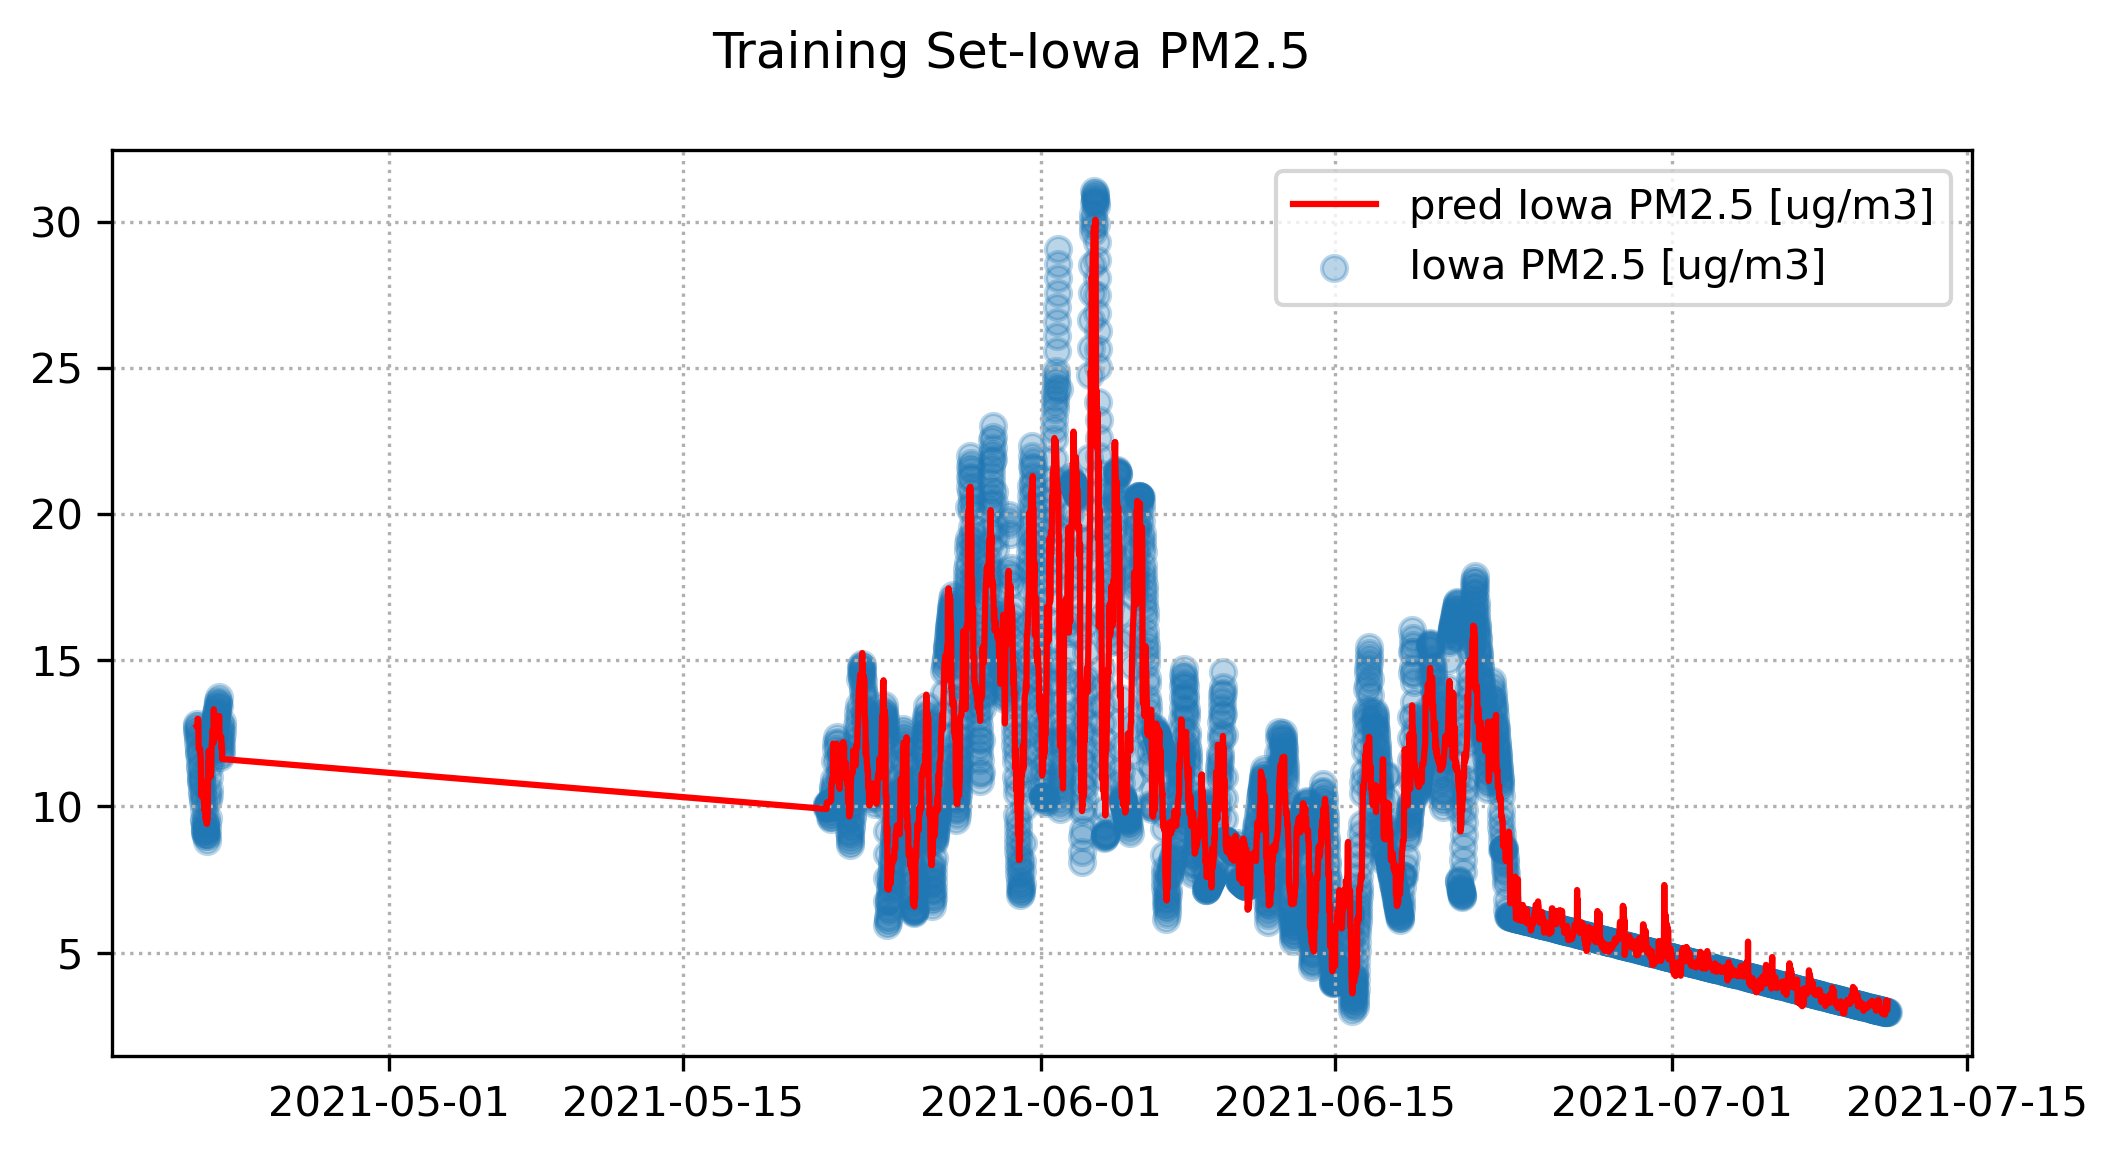

In [18]:
train_fig, train_ax = plt.subplots(dpi=300, figsize=(8, 4))
iowa_train_x.sort_index(inplace=True)
train_ax.plot(
    iowa_train_x.index.values,
    gbt_model_loo.predict(iowa_train_x),
    color='red',
    label='pred Iowa PM2.5 [ug/m3]'
)
train_ax.scatter(
    iowa_train_y.index.values,
    iowa_train_y,
    alpha=0.3,
    label='Iowa PM2.5 [ug/m3]'
)
train_fig.suptitle('Training Set-Iowa PM2.5')
train_ax.grid(linestyle=':')
train_ax.legend()
if SAVE_FIGURES:
    train_fig.savefig('../graphs/travel_time/Iowa_Training_Data.png', dpi=300)

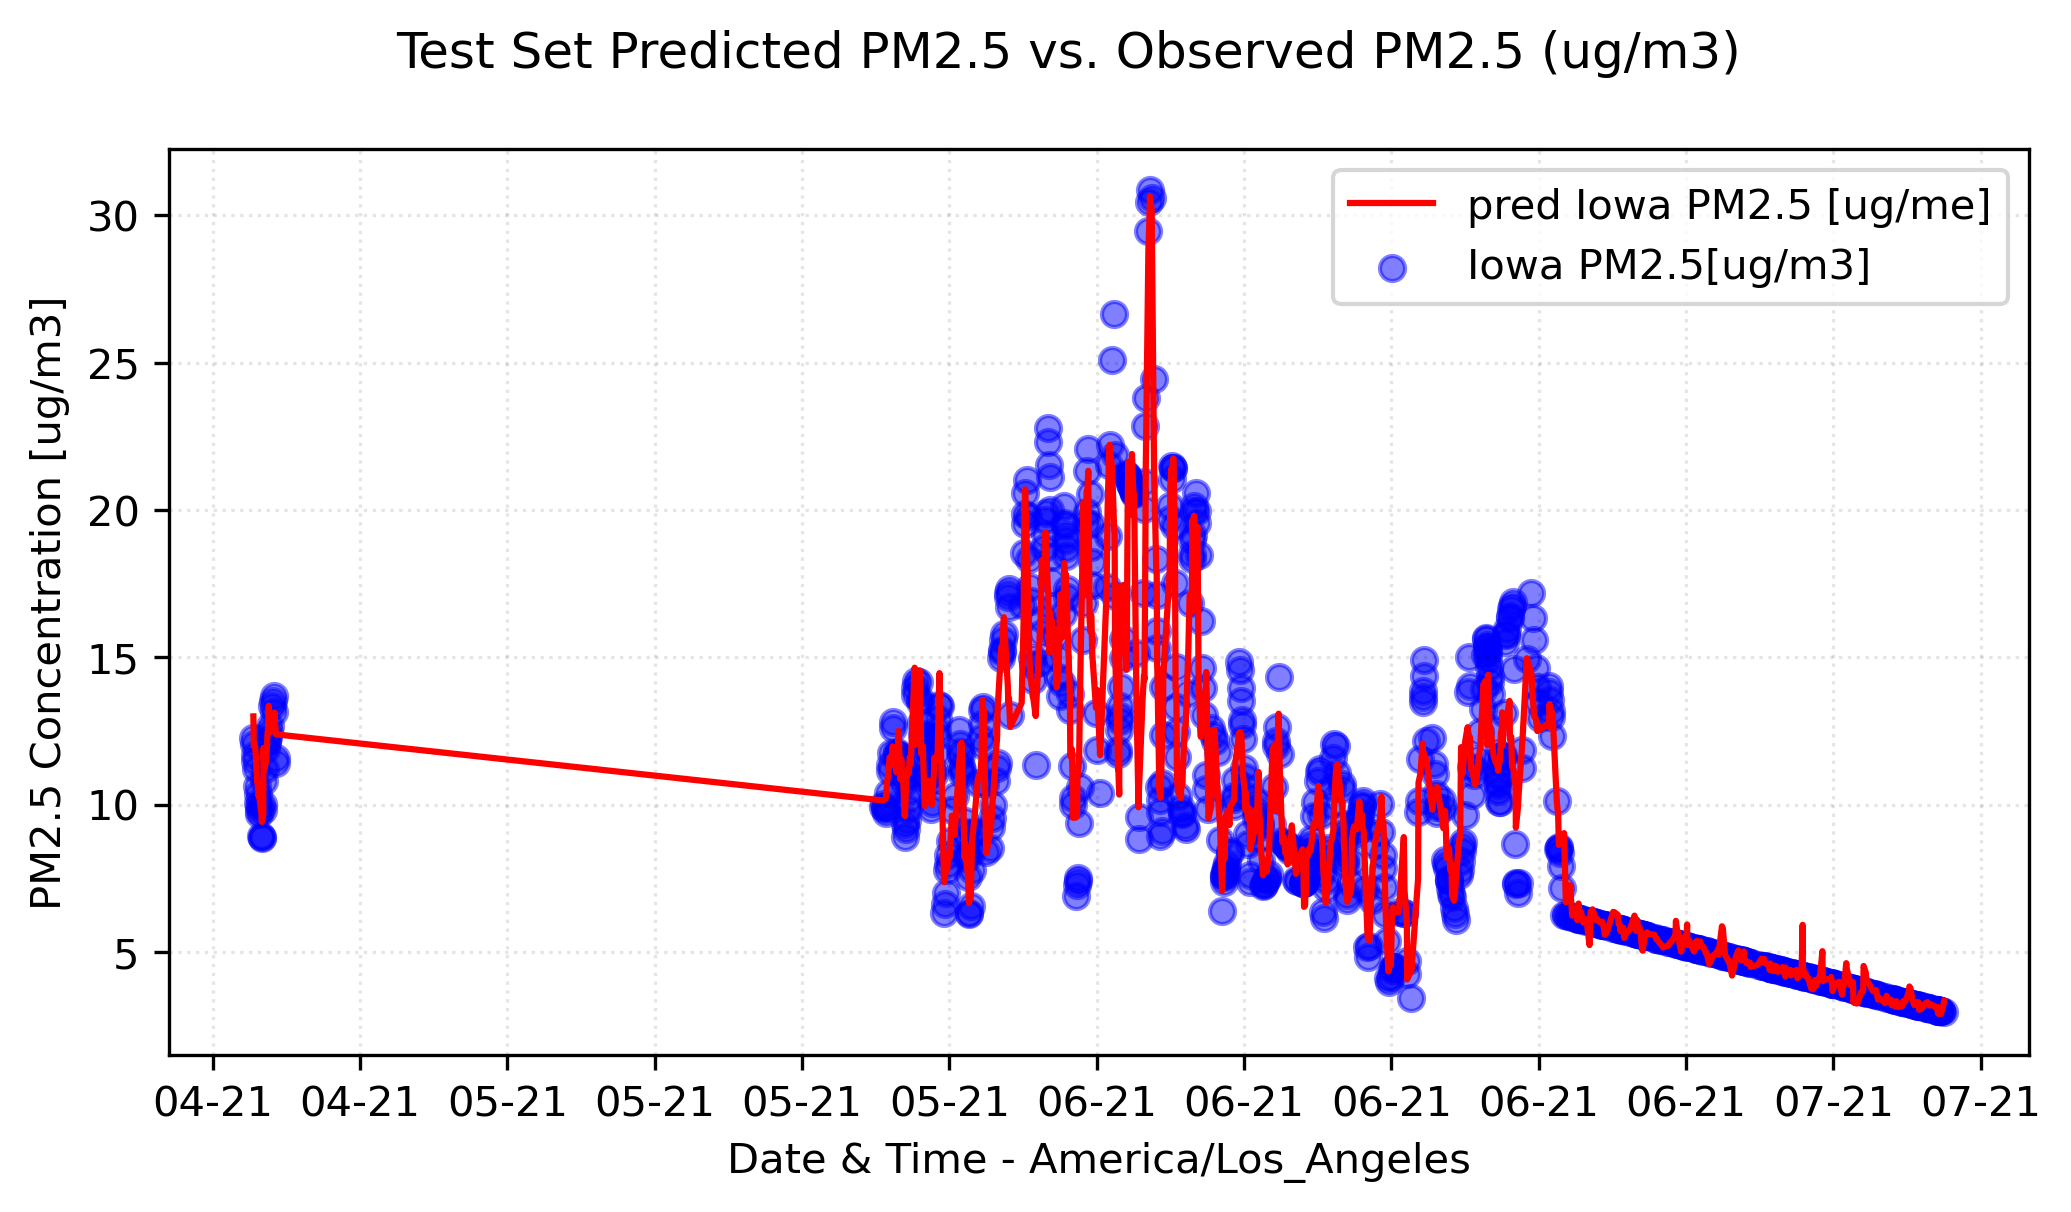

In [19]:
valid_fig, valid_ax = plt.subplots(dpi=300, figsize=(8, 4))
valid_ax.plot(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, 'pred Iowa PM2.5 [ug/m3]'],
    color='red',
    label='pred Iowa PM2.5 [ug/me]'
)
valid_ax.scatter(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, 'Iowa PM2.5 [ug/m3]'],
    alpha=0.5,
    color='blue',
    label='Iowa PM2.5[ug/m3]'
)
valid_ax.set_ylabel('PM2.5 Concentration [ug/m3]')
valid_ax.set_xlabel('Date & Time - America/Los_Angeles')
valid_ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1))
valid_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
valid_ax.grid(axis='both', alpha=0.1, color='black', linestyle=':')
valid_fig.suptitle('Test Set Predicted PM2.5 vs. Observed PM2.5 (ug/m3)')
valid_ax.legend()
if SAVE_FIGURES:
    valid_fig.savefig('../graphs/travel_time/Iowa_Test_Evaluation.png', dpi=300)

***
# __Partial Dependence__
***

In [20]:
print(dtk.df_getColNames(iowa_train_x))
iowa_train_x

['year', 'month', 'day', 'dayofweek_Sunday', 'dayofweek_Monday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayofweek_Thursday', 'dayofweek_Friday', 'dayofweek_Saturday', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'PM2.5 Background [ug/m3]', 'Local 1 (mph)', 'Local 2 (mph)', 'Local 9 (mph)', 'Local 10 (mph)', 'Fwy 1 (mph)', 'Fwy 4 (mph)']


,year,month,day,dayofweek_Sunday,dayofweek_Monday,dayofweek_Tuesday,dayofweek_Wednesday,dayofweek_Thursday,dayofweek_Friday,dayofweek_Saturday,temp,pressure,humidity,wind_speed,wind_deg,PM2.5 Background [ug/m3],Local 1 (mph),Local 2 (mph),Local 9 (mph),Local 10 (mph),Fwy 1 (mph),Fwy 4 (mph)
datetime-America/Los_Angeles,,,,,,,,,,,,,,,,,,,,,,
2021-04-21 14:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.077474,14.268458,18.500068,12.143368,20.245579,18.390919
2021-04-21 14:15:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,14.725029,13.229034,17.702651,12.384627,20.089243,18.833312
2021-04-21 14:30:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.650210,14.067494,16.695183,13.357705,20.404368,18.768815
2021-04-21 14:45:00-07:00,2021,4,21,0,0,0,1,0,0,0,17.92,1012,57,2.24,298,7.0,13.551295,14.796919,16.832029,12.721624,19.935302,15.481621
2021-04-21 15:00:00-07:00,2021,4,21,0,0,0,1,0,0,0,18.31,1011,55,1.79,275,9.0,13.262970,14.067494,18.172633,12.550864,19.560578,17.020167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-10 21:00:00-07:00,2021,7,10,0,0,0,0,0,0,1,26.71,1013,46,0.45,174,4.0,14.275410,13.056105,16.971136,12.222737,23.977483,20.148875
2021-07-10 21:30:00-07:00,2021,7,10,0,0,0,0,0,0,1,26.71,1013,46,0.45,174,4.0,15.328514,15.729009,18.668250,12.467192,24.542990,20.998061
2021-07-10 22:00:00-07:00,2021,7,10,0,0,0,0,0,0,1,25.80,1014,46,0.89,227,6.0,13.852435,15.248734,18.839518,13.262970,24.895281,20.223225


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   13.5s finished


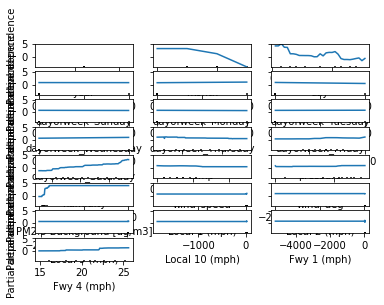

In [21]:
display = PartialDependenceDisplay.from_estimator(
    gbt_model_loo,
    X=iowa_train_x,
    features=nLoop(dtk.df_getColNames(iowa_train_x)),
    feature_names=dtk.df_getColNames(iowa_train_x),
    verbose=True,
    n_jobs=PARALLEL_CORES,
    method='auto',
    kind='average',
    random_state=RANDOM_STATE,
    grid_resolution=150,
    subsample=0.1
)

In [22]:
partial_fig = []
partial_ax = []
for n in nLoop(dtk.df_getColNames(iowa_train_x)):
    fig, ax = plt.subplots(dpi=300)
    plt.close(fig)
    partial_fig.append(fig)
    partial_ax.append(ax)
display.plot(ax=partial_ax)

In [23]:

full_partial_fig, full_partial_ax = plt.subplots(nrows=11, ncols=2, dpi=300, figsize=(22, 44))
display.plot(ax=full_partial_ax)


def activate_grid(x):
    x.grid(linestyle=':')


activate_grid_v = np.vectorize(activate_grid)
activate_grid_v(full_partial_ax)
full_partial_fig.savefig('../graphs/travel_time/full_partial_dependence.png', dpi=300, facecolor='white',
                         edgecolor='azure')
full_partial_fig

In [25]:
partial_feats = dtk.df_getColNames(iowa_train_x)
feat_filenames = ['year', 'month', 'day', 'dayofweek_01_Sunday', 'dayofweek_02_Monday', 'dayofweek_03_Tuesday',
                  'dayofweek_04_Wednesday', 'dayofweek_05_Thursday', 'dayofweek_06_Friday', 'dayofweek_07_Saturday',
                  'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'background_pm25', 'travelTime_local1',
                  'travelTime_local2', 'travelTime_local9', 'travelTime_local10', 'travelTime_fwy1', 'travelTime_fwy2']
for i in nLoop(partial_fig):
    partial_fig[i].suptitle(f'Partial Dependence - {partial_feats[i]}')
    partial_ax[i].grid(linestyle=':')
    partial_fig[i].savefig(
        f'../graphs/travel_time/partial_dependence/partial_dependence_{feat_filenames[i]}.png',
        dpi=300,
        facecolor='white', edgecolor='azure')